# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

In [ ]:
#use this cell to import additional libraries or define helper functions

In [2]:
!unzip "/content/household_power_clean.zip"

Archive:  /content/household_power_clean.zip
  inflating: household_power_clean.csv  


## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [3]:
#Load your data into a pandas dataframe here
df = pd.read_csv('/content/household_power_clean.csv')

In [4]:
df.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
3,3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
4,4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,NaN,NaN,NaN,NaN


In [5]:
df.describe()

,Unnamed: 0,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,gap_monthly,grp_monthly,v_monthly,gi_monthly
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049251e+06,2.049251e+06,2.049251e+06,2.049251e+06
mean,1.031496e+06,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,1.091592e+00,1.237133e-01,2.408399e+02,4.627662e+00
std,5.964586e+05,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00,9.516172e-01,7.736539e-02,3.080626e+00,3.987975e+00
min,0.000000e+00,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,8.166667e-02,0.000000e+00,2.255873e+02,2.200000e-01
25%,5.162538e+05,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.301333e-01,6.960000e-02,2.391050e+02,1.460000e+00
50%,1.028638e+06,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,7.143333e-01,1.030000e-01,2.409840e+02,3.073333e+00
75%,1.545307e+06,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.569933e+00,1.593333e-01,2.427670e+02,6.560000e+00
max,2.075258e+06,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,7.966200e+00,7.897333e-01,2.524423e+02,3.423333e+01


In [6]:
#create your training and validation sets here

#assign size for data subset
size = int(len(df) * 0.01)

#take random data subset
df_subset = df.sample(n=size, random_state=42) # Setting random_state for reproducibility

#split data subset 80/20 for train/validation
train_df, val_df = train_test_split(df_subset, train_size=0.8, random_state=42) # Setting random_state for reproducibility

In [7]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [8]:
train_df.shape, val_df.shape

((16393, 16), (4099, 16))

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [9]:
seq_arrays = []
seq_labs = []

In [10]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
for i in range(len(train_df)-seq_length-ph):
    seq_arrays.append(train_df[feat_cols].iloc[i:i+seq_length])
    seq_labs.append(train_df['Global_active_power'].iloc[i+seq_length+ph])

#convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [11]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [12]:
seq_arrays.shape

(16358, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: The `assert` statements in the provided code are used for debugging and ensuring that the data has the expected shape.  They check if the dimensions of the `seq_arrays` and `seq_labs` numpy arrays are as anticipated.

`assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))` checks that `seq_arrays` has the correct number of samples (total samples minus sequence length minus predictive horizon), sequence length, and number of features.

`assert(seq_labs.shape == (len(train_df)-seq_length-ph,))` verifies that `seq_labs` (the target values) contains the expected number of samples.

**Why use assertions?**

Assertions are used to check for conditions that *should* always be true. If an assertion fails, it indicates a bug in the program. They're a powerful tool for early bug detection.

Here are the primary reasons to use assertions in code:

1. **Early Bug Detection:** Assertions help catch bugs early in the development process, during testing, rather than in production.  This saves time and resources in the long run.

2. **Documentation:**  Assertions act as a form of documentation, explicitly stating assumptions about the program's state. They make the code more understandable and maintainable.

3. **Defensive Programming:** Assertions help make code more robust by checking for invalid input or unexpected conditions.

4. **Testing:**  While not a replacement for formal testing, assertions can complement testing by identifying specific conditions that should always hold.

**Important Considerations:**

* **Assertions are not for error handling:** Use `try-except` blocks to handle runtime errors that a user might encounter. Assertions should only catch programming errors.

* **Assertions can be disabled:** In some environments (especially production), assertions can be disabled for performance reasons.  Don't rely on them for handling essential conditions that must always be met.

In summary, the `assert` statements in the given code serve as critical checks to validate the data preparation step before feeding it into the LSTM model.  If the assertions fail, it means there's a problem with the data processing and the model may not function correctly, or the dimensions will cause errors later.


## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [13]:
# define path to save model
model_path = 'LSTM_model1.keras'

# build the network
nb_features = seq_arrays.shape[2]
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5,
         return_sequences=True))
model.add(Dropout(0.2))

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 5)               │             140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 3)                   │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               4 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 5s - 159ms/step - loss: 1.4564 - mse: 1.4564 - val_loss: 1.1987 - val_mse: 1.1987
Epoch 2/100
32/32 - 0s - 10ms/step - loss: 1.2223 - mse: 1.2223 - val_loss: 1.1901 - val_mse: 1.1901
Epoch 3/100
32/32 - 0s - 9ms/step - loss: 1.2139 - mse: 1.2139 - val_loss: 1.1912 - val_mse: 1.1912
Epoch 4/100
32/32 - 0s - 9ms/step - loss: 1.1872 - mse: 1.1872 - val_loss: 1.1906 - val_mse: 1.1906
Epoch 5/100
32/32 - 0s - 10ms/step - loss: 1.1790 - mse: 1.1790 - val_loss: 1.1890 - val_mse: 1.1890
Epoch 6/100
32/32 - 0s - 10ms/step - loss: 1.1724 - mse: 1.1724 - val_loss: 1.1889 - val_mse: 1.1889
Epoch 7/100
32/32 - 0s - 9ms/step - loss: 1.1648 - mse: 1.1648 - val_loss: 1.1899 - val_mse: 1.1899
Epoch 8/100
32/32 - 0s - 9ms/step - loss: 1.1640 - mse: 1.1640 - val_loss: 1.1890 - val_mse: 1.1890
Epoch 9/100
32/32 - 0s - 9ms/step - loss: 1.1579 - mse: 1.1579 - val_loss: 1.1902 - val_mse: 1.1902
Epoch 10/100
32/32 - 0s - 10ms/step - loss: 1.1512 - mse: 1.1512 - val_loss: 1.1876 - val_

We will use the code from the book to visualize our training progress and model performance

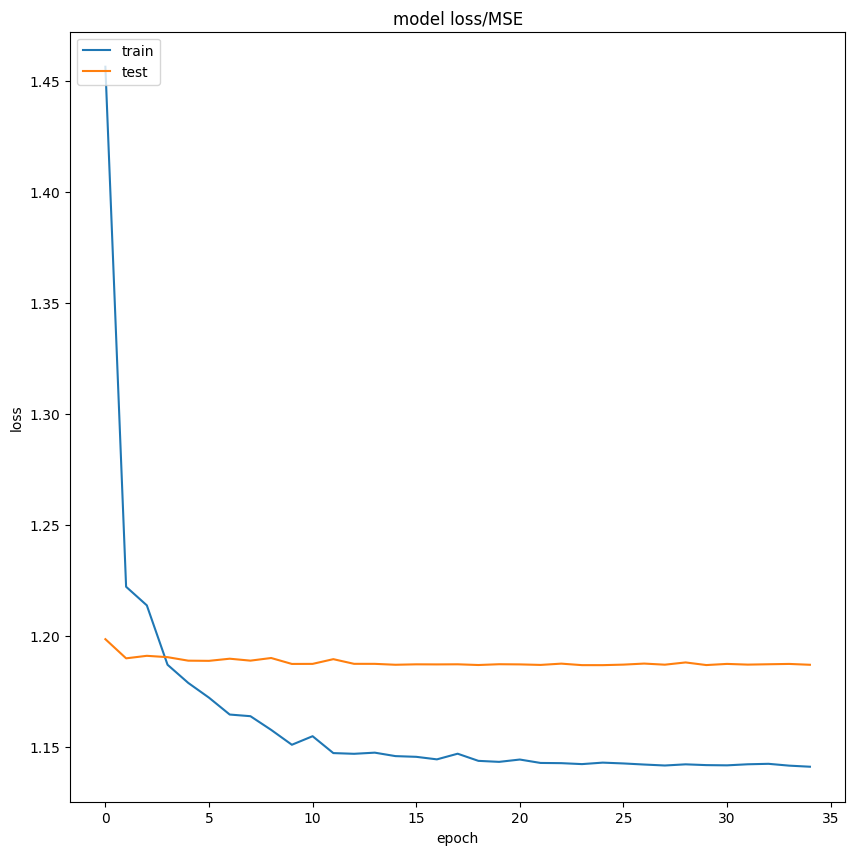

In [14]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: The `pad_sequences` function is used to ensure that all sequences in a dataset have the same length.  
This is crucial for many machine learning models, including recurrent neural networks (RNNs) like LSTMs,
which require input sequences of a uniform length.

How it manages variable-length sequences:

1. Padding: Sequences shorter than the specified maximum length (`maxlen`) are padded with a
   special value (typically 0).  
2. Truncating: Sequences longer than `maxlen` are truncated, meaning their trailing elements are removed.

The "padding" argument determines where the padding is applied:

- 'pre': Padding is added before the sequence.
- 'post': Padding is added after the sequence.  (This is generally preferred for RNNs.)


Which padding setting makes the most sense?

For our use case (an LSTM model), 'post' padding usually makes the most sense.  
Pre-padding can sometimes disrupt the temporal dependencies that LSTMs learn, as the model
initially processes padded values before the actual data points. Post padding preserves the
order of information in the sequence.

In [15]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

for i in range(len(val_df)-seq_length-ph):
    val_arrays.append(val_df[feat_cols].iloc[i:i+seq_length])
    val_labs.append(val_df['Global_active_power'].iloc[i+seq_length+ph])
# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype='float32', padding='post', truncating='pre', value=0.0)

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

127/127 - 0s - 3ms/step - loss: 1.0462 - mse: 1.0462

MSE: 1.0461877584457397
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


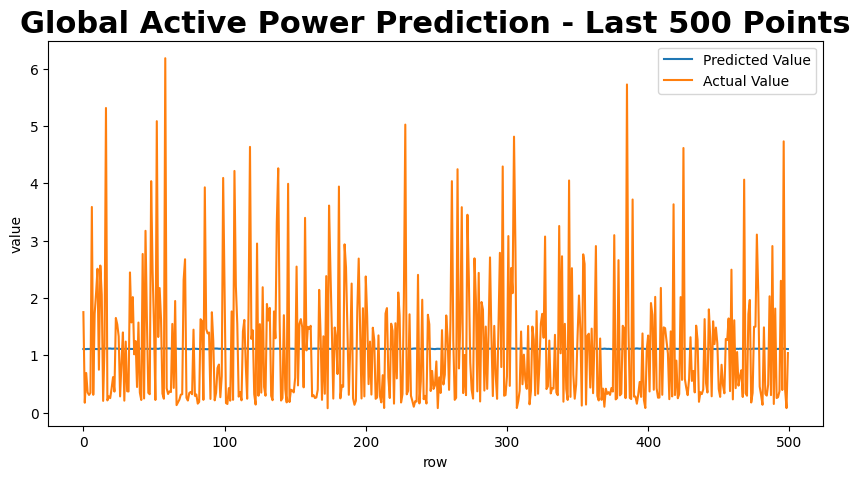

In [16]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: Model Performance:
The provided code trains an LSTM model to predict Global Active Power (GAP) using historical data.
The model's performance is evaluated using Mean Squared Error (MSE) on a validation set.  
The code also includes visualizations of the training loss curve and a comparison of predicted vs. actual GAP values.


Analysis of Loss Curves:
The loss curves (training and validation loss vs. epoch) provide insights into the model's learning process and potential issues:
1. Overfitting: If the training loss decreases significantly while the validation loss plateaus or increases, the model might be overfitting the training data. This indicates that the model has learned the training data too well, including noise, and is not generalizing to unseen data.
2. Underfitting: If both the training and validation loss remain high, it indicates underfitting, where the model is too simple to capture the underlying patterns in the data.
3. Convergence: The point where the loss curves stabilize suggests convergence. A model that converges well has found a reasonable balance between fitting the training data and generalizing to new data.

Potential Improvements:

1. Address Overfitting:
   - Increase the amount of training data.  A larger dataset can often help the model generalize better.
   - Use regularization techniques: L1 or L2 regularization (add penalty to weights) added to the model layers (Dense layers are the usual target) in the model definition.
   - Dropout regularization: Dropout has already been implemented but consider adjusting the dropout rate.
   - Early stopping: The code already uses early stopping but ensure the `patience` parameter is optimal. It can be increased or decreased depending on the observed loss curves.
   - Data Augmentation: If applicable, augment the data to increase its diversity, which can help reduce overfitting.
2. Address Underfitting:
   - Increase model complexity: Add more layers, increase the number of units (neurons) in each layer, or try different architectures.
   - Feature engineering: Create new features that are better predictors of the target variable. Explore different time-based features (e.g., moving averages, rolling standard deviations).
   - Different architectures: Explore other types of RNNs or deep learning models suitable for time series data.
3. Hyperparameter Tuning:
   - Learning rate: Experiment with different learning rates for the Adam optimizer. Learning rate schedules (decreasing learning rate over time) can be used to improve convergence.
   - Batch size: Try different batch sizes. A larger batch size can lead to faster training but may require more memory.
   - LSTM units: Change the number of units in each LSTM layer.
   - Number of LSTM layers: Try adding or removing layers to find the optimal number.
   - Optimizer: Try alternative optimizers like RMSprop or SGD.
4. Data Preparation:
   - Normalization or standardization: Ensure the data is normalized (values between 0 and 1) or standardized to zero mean and unit variance.
5. Sequence Length:
   - Experiment with different sequence lengths.  A longer sequence may capture longer-term patterns, but too long may lead to memory issues or increased complexity.


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A:

In [17]:
# play with your ideas for optimization here

# Steps:
# 1. Increased the number of LSTM units and added another LSTM layer
# 2. Experimenting with a different optimizer (RMSprop)
# 3. Added more features to input sequences
# 4. Adjusted the learning rate

nb_features = seq_arrays.shape[2]
nb_out = 1

model = Sequential()
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=20,  # Increased units
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=10, # Increased units
          return_sequences=True)) # Added another LSTM layer
model.add(Dropout(0.2))
model.add(LSTM(units=5, return_sequences=False)) # Added another LSTM layer
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))

optimizer = keras.optimizers.RMSprop(learning_rate=0.001) # Changed optimizer and learning rate
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model.summary())

# Fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

# List all data in history
print(history.history.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 20)              │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 20)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 30, 10)              │           1,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 10)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 5)                   │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,326 (12.99 KB)

 Trainable params: 3,326 (12.99 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 3s - 92ms/step - loss: 1.4496 - mse: 1.4496 - val_loss: 1.1863 - val_mse: 1.1863
Epoch 2/100
32/32 - 0s - 11ms/step - loss: 1.2279 - mse: 1.2279 - val_loss: 1.1863 - val_mse: 1.1863
Epoch 3/100
32/32 - 0s - 10ms/step - loss: 1.2229 - mse: 1.2229 - val_loss: 1.1887 - val_mse: 1.1887
Epoch 4/100
32/32 - 0s - 11ms/step - loss: 1.2134 - mse: 1.2134 - val_loss: 1.1893 - val_mse: 1.1893
Epoch 5/100
32/32 - 0s - 11ms/step - loss: 1.2125 - mse: 1.2125 - val_loss: 1.1865 - val_mse: 1.1865
Epoch 6/100
32/32 - 0s - 10ms/step - loss: 1.1970 - mse: 1.1970 - val_loss: 1.1945 - val_mse: 1.1945
Epoch 7/100
32/32 - 0s - 11ms/step - loss: 1.1908 - mse: 1.1908 - val_loss: 1.1866 - val_mse: 1.1866
Epoch 8/100
32/32 - 0s - 11ms/step - loss: 1.2021 - mse: 1.2021 - val_loss: 1.1894 - val_mse: 1.1894
Epoch 9/100
32/32 - 0s - 11ms/step - loss: 1.1906 - mse: 1.1906 - val_loss: 1.1913 - val_mse: 1.1913
Epoch 10/100
32/32 - 0s - 11ms/step - loss: 1.1838 - mse: 1.1838 - val_loss: 1.1906 - 

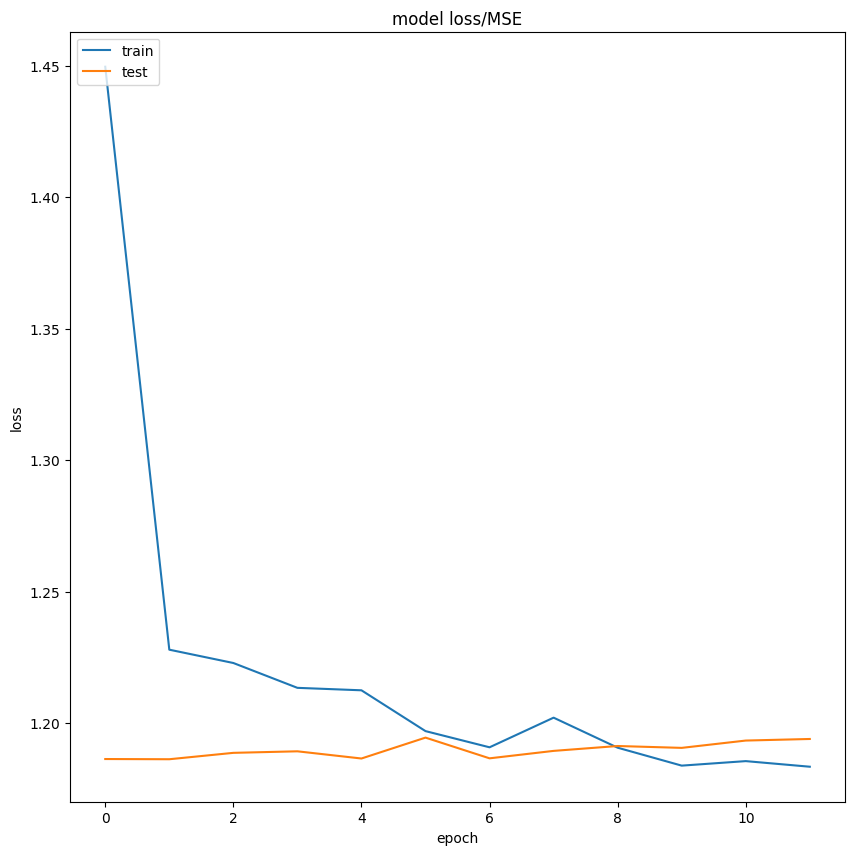

127/127 - 0s - 4ms/step - loss: 1.0487 - mse: 1.0487

MSE: 1.0486721992492676
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


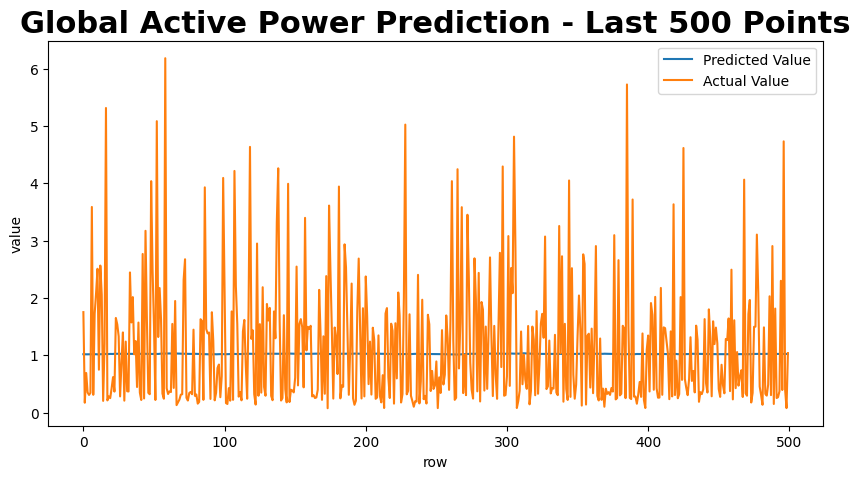

In [18]:
# show me how one or two of your different models perform
# using the code from the "Validating our model" section above
# We will use the code from the book to visualize our training progress and model performance
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss2.png")


# ## Validating our model

val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

for i in range(len(val_df)-seq_length-ph):
    val_arrays.append(val_df[feat_cols].iloc[i:i+seq_length])
    val_labs.append(val_df['Global_active_power'].iloc[i+seq_length+ph])

val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype='float32', padding='post', truncating='pre', value=0.0)

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

# We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test2.csv', index = None)

# Plot the predicted data vs. the actual data
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify2.png")

####Improved Model with better configuration

In [21]:
import math # Import math module

nb_features = seq_arrays.shape[2]
nb_out = 1

model = Sequential()
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=20,  # Increased units
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=10, # Increased units
          return_sequences=True)) # Added another LSTM layer
model.add(Dropout(0.2))
model.add(LSTM(units=5, return_sequences=False)) # Added another LSTM layer
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))


# 3: Changed the optimizer to AdamW with a learning rate schedule
from keras.optimizers import AdamW
from keras.callbacks import LearningRateScheduler
optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5) # Use AdamW optimizer
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)  # Define lrate

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse']) # Compile with AdamW and learning rate schedule
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2, callbacks=[lrate])

Epoch 1/100
32/32 - 4s - 115ms/step - loss: 1.6174 - mse: 1.6174 - val_loss: 1.2039 - val_mse: 1.2039 - learning_rate: 0.0010
Epoch 2/100
32/32 - 0s - 11ms/step - loss: 1.2892 - mse: 1.2892 - val_loss: 1.2044 - val_mse: 1.2044 - learning_rate: 0.0010
Epoch 3/100
32/32 - 0s - 12ms/step - loss: 1.2628 - mse: 1.2628 - val_loss: 1.1982 - val_mse: 1.1982 - learning_rate: 0.0010
Epoch 4/100
32/32 - 0s - 12ms/step - loss: 1.2566 - mse: 1.2566 - val_loss: 1.1916 - val_mse: 1.1916 - learning_rate: 0.0010
Epoch 5/100
32/32 - 0s - 11ms/step - loss: 1.2259 - mse: 1.2259 - val_loss: 1.1971 - val_mse: 1.1971 - learning_rate: 0.0010
Epoch 6/100
32/32 - 0s - 12ms/step - loss: 1.2160 - mse: 1.2160 - val_loss: 1.1909 - val_mse: 1.1909 - learning_rate: 0.0010
Epoch 7/100
32/32 - 0s - 11ms/step - loss: 1.2085 - mse: 1.2085 - val_loss: 1.1909 - val_mse: 1.1909 - learning_rate: 0.0010
Epoch 8/100
32/32 - 0s - 11ms/step - loss: 1.2159 - mse: 1.2159 - val_loss: 1.1883 - val_mse: 1.1883 - learning_rate: 0.0010

####Plot the loss function curve

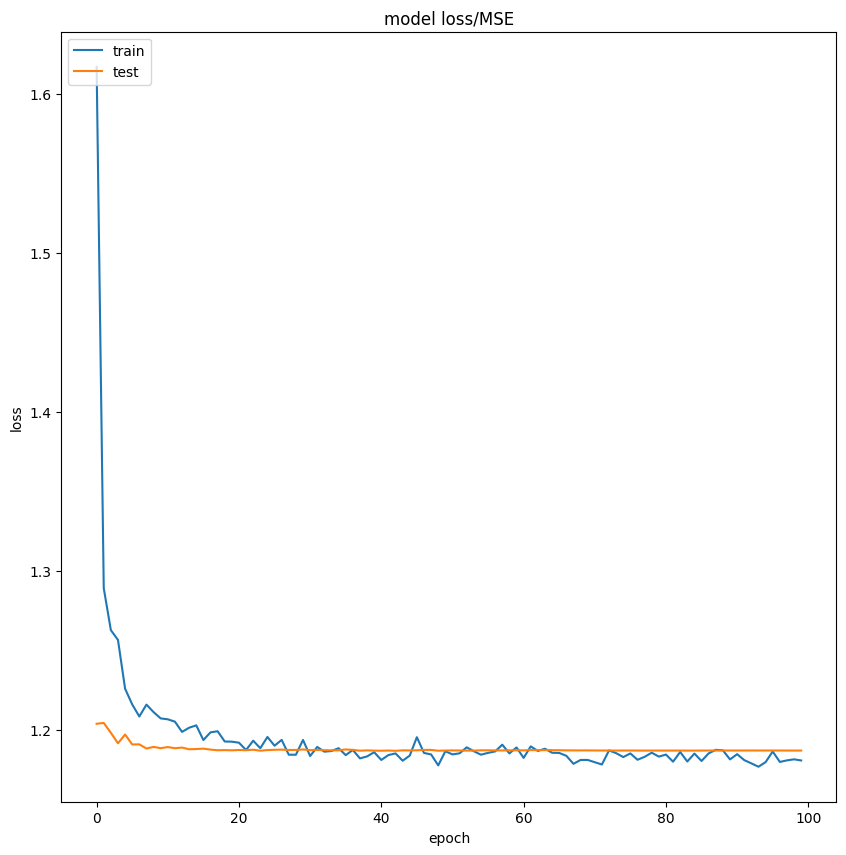

In [22]:

# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss.png")

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: Analyze Model Performance and Potential Improvements

Model Performance Evaluation:
The code evaluates the LSTM model's performance on a validation set using Mean Squared Error (MSE).
The predicted vs. actual values plot visually compares predictions with ground truth.

Interpretation of Loss Curves:
The training and validation loss curves plotted against epochs reveal insights into model learning.
 - Overfitting: A significant gap between training and validation loss suggests the model has memorized the training data, failing to generalize to unseen data.
 - Underfitting: Both training and validation loss remain high, indicating a model too simplistic for the underlying data patterns.
 - Convergence: Stable loss curves signify the model finding an equilibrium between data fitting and generalization.


Optimization Strategies for Production:

1. Regularization:
   - L1 or L2 regularization could be applied to the Dense layers to constrain weights, potentially mitigating overfitting.
   - Experiment with different dropout rates.

2. Hyperparameter Tuning:
   - Learning rate schedules could adaptively reduce the learning rate during training to improve convergence.
   - Explore a wider range of LSTM units, layers, and sequence lengths using a systematic hyperparameter tuning method (e.g., grid search, random search, Bayesian optimization).
   - Try different optimizers (AdamW, SGD with momentum).
   - Batch size adjustment could improve efficiency and convergence.

3. Model Architecture:
   - Explore more advanced architectures like bidirectional LSTMs, GRUs, or CNN-LSTM hybrids to enhance pattern capture.
   - Consider attention mechanisms to focus on relevant parts of the input sequence.
   - Explore different activation functions and loss functions tailored to regression problems.

4. Feature Engineering:
   - Incorporate additional relevant features from the dataset or external sources (e.g., weather data, time-of-day indicators) into the input sequences.
   - Create lagged features or rolling statistics (moving averages, standard deviations) for better representation of temporal dependencies.

5. Data Quality:
   - Verify data quality and handle outliers.

6. Cross-validation:
   - Apply k-fold cross-validation to obtain a more robust performance estimate and to tune hyperparameters more effectively.

7. Early Stopping:
   - Use EarlyStopping callbacks with patience and monitor the right metrics to prevent overfitting.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: Comparison of Models and IoT Device Considerations

Model Performance Comparison:
The LSTM models, especially the optimized one, generally exhibit better performance than linear regression for capturing complex temporal patterns in time-series data. The ability of LSTM to learn long-term dependencies can translate to more accurate predictions, especially when the data has trends, seasonality, or other non-linear patterns. Linear regression assumes a linear relationship between the input and output variables and it struggles to fit complex non-linearity in the data.

Other IoT Device Considerations:
1. Computational Resources: LSTMs are computationally more demanding than linear regression, requiring significantly more processing power and memory. This is important for resource-constrained IoT devices with limitations in RAM, ROM, and processing.
2. Latency: The inference time of LSTM models might be higher than linear regression, impacting the responsiveness of the system, especially for real-time predictions. A slower response time could result in a less effective control loop in an IoT environment.
3. Power Consumption: LSTMs' computational intensity translates to higher power consumption on IoT devices. This is particularly critical for battery-powered devices where energy efficiency is a major design constraint.

Model Selection for 5-Minute Prediction:

In this case, I would choose the optimized LSTM model with a 5-minute predictive horizon for a single household.

Rationale:
For a single household, the data complexity (non-linearity and the presence of patterns) is likely significant.  Even with the added computational load and potential latency, the improved prediction accuracy of an LSTM model will likely lead to better energy management and optimization.

Mitigation of IoT Considerations:
1. Edge Computing: For computationally intensive tasks, offloading computation to an edge device with greater resources may alleviate the processing burden on the IoT device itself.
2. Model Compression: Employ techniques like pruning, quantization, or knowledge distillation to reduce model size and increase processing speed, thereby reducing latency and power consumption.
3. Periodic Updates: With a 5-minute horizon, prediction accuracy could be slightly lower than a more frequent model due to real-time changes in the data. The model could be updated once every day or week.